In [1]:
# import libraries
import pandas as pd
import numpy as np
import pickle5 as pickle
import math
import matplotlib.pyplot as plt
from matplotlib import colors

import cv2
from scipy.ndimage import median_filter
from skimage.transform import resize as sk_resize
from skimage.util import img_as_ubyte
from skimage.morphology import skeletonize, thin

import time

In [2]:
# load data
with open('WM-clean.pkl', "rb") as fh:
    raw_data = pickle.load(fh)
print(f'Raw data shape: {raw_data.shape}')
raw_data.head()

Raw data shape: (172950, 11)


,waferMap,dieSize,lotName,waferIndex,failureType,encoding,x_,y_,shape,labels,dataset
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",test
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",test
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train


In [3]:
# add index column to identify specific wafers 
raw_data.reset_index(inplace=True)
raw_data = raw_data.rename(columns={'index':'ID'})

# add detection model labels
raw_data['detectLabels'] = raw_data['failureType'].apply(lambda x: 0 if x == 'none' else 1)

# add classification model labels
fail_dict = {'none': 8, 'Loc': 0, 'Edge-Loc': 1, 'Center': 2, 'Edge-Ring': 3, 
             'Scratch': 4, 'Random': 5, 'Near-full': 6, 'Donut': 7}
raw_data['classifyLabels'] = raw_data['failureType'].apply(lambda x: fail_dict[x])

raw_data.head()

,ID,waferMap,dieSize,lotName,waferIndex,failureType,encoding,x_,y_,shape,labels,dataset,detectLabels,classifyLabels
0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train,0,8
1,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",test,0,8
2,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",test,0,8
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train,0,8
4,4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train,0,8


In [4]:
train = raw_data[raw_data.dataset == 'train'].reset_index(drop=True)
len(train)

121065

In [5]:
# keep only columns needed for modeling
paper_train = train[['ID', 'waferMap', 'classifyLabels']]
paper_train.head()

,ID,waferMap,classifyLabels
0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",8
1,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",8
2,4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",8
3,6,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",8
4,7,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",8


In [6]:
# create detund dataset
# make list of none indices
none_df = paper_train[paper_train.classifyLabels == 8]
none_list = none_df.index.tolist()
print(f'None count: {len(none_list)}')

# make list of defect indices
def_df = paper_train[paper_train.classifyLabels != 8]
def_list = def_df.index.tolist()
print(f'Defect count: {len(def_list)}')

# randomly undersample none list
from random import sample, seed
seed(424)
under_none = sample(none_list, 30000)

# recombine defect indices with undersampled none indices
new_list = sorted(under_none + def_list)
print(f'Undersampled dataset count: {len(new_list)}')

# undersample data
undersampled = paper_train.iloc[new_list].reset_index(drop=True)
print(undersampled.shape)
undersampled.head()

None count: 103202
Defect count: 17863
Undersampled dataset count: 47863
(47863, 3)


,ID,waferMap,classifyLabels
0,9,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",8
1,36,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
2,37,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
3,38,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
4,39,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0


In [7]:
# resize to 60x60
start = time.time()

def preprocess(x):
    y = sk_resize(x, [60,60])
    new_y = img_as_ubyte(y)
    ret, thresh_img = cv2.threshold(new_y, 1, 1, cv2.THRESH_BINARY)
    return thresh_img
    
undersampled['binaryMap'] = undersampled.waferMap.apply(lambda x: preprocess(x))

# check that resizing worked
walltime = time.time() - start
print(f'Time: {walltime:.3f} seconds')
print(undersampled.binaryMap[2].shape)
print(np.unique(undersampled.binaryMap[2]))

Time: 34.585 seconds
(60, 60)
[0 1]


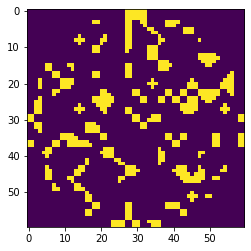

In [8]:
plt.imshow(undersampled.binaryMap[23135])

In [9]:
# apply thinning n=2
start = time.time()

undersampled['thinMap2'] = undersampled.binaryMap.apply(lambda x: thin(x, 2))

# change thinMap columns to uint8
undersampled['thinMap2'] = undersampled.thinMap2.apply(lambda x: x.astype(np.uint8))

walltime = time.time() - start
print(f'Time: {walltime:.3f} seconds')

Time: 17.046 seconds


In [10]:
# save undersampled dataset, keeping only needed columns
undersampled = undersampled.drop(['waferMap', 'binaryMap'], axis=1)
with open('WM-clean60-thin2/WM-clean60-thin2-train-all.pkl', "wb") as f:
    pickle.dump(undersampled, f)

# sanity check
undersampled.head()

,ID,classifyLabels,thinMap2
0,9,8,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,36,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,37,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,38,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,39,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [11]:
len(undersampled)

47863